In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision.io import read_image, ImageReadMode, write_video
import torchvision.transforms as T
from random import randint
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pylab as pl
from importlib import reload  

from scripts import *
from CAModel import *

In [2]:
N_CHANNELS = 16        # Number of CA state channels
TARGET_PADDING = 16    # Number of pixels used to pad the target image border
TARGET_SIZE = 40       # Size of the target emoji
IMAGE_SIZE = TARGET_PADDING+TARGET_SIZE
BATCH_SIZE = 1
N_ITERS = 50           # Iterations before applying the loss
POOL_SIZE = 1024
CELL_FIRE_RATE = 0.5

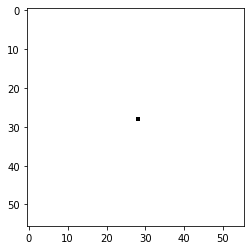

In [3]:
# Starting state
pool = SamplePool(POOL_SIZE, N_CHANNELS, IMAGE_SIZE)
imshow(pool[0][0])

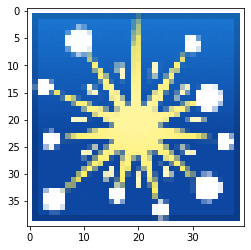

In [4]:
# Imports the target emoji
target = read_image("firework.png", ImageReadMode.RGB_ALPHA).float()
target = T.Resize((TARGET_SIZE, TARGET_SIZE))(target)
target = RGBAtoFloat(target)

imshow(target)

In [5]:
# Custom loss function
class loss_fn:
    """Custom l2 or l1 loss function"""
    def __init__(self, target, order=2):
        self.order = order
        self.target = target
        
    def __call__(self, x):
        return torch.mean(torch.abs(x[:, :4, :, :] - self.target)**self.order)

target = target.cpu()
loss_fn(Pad(target, TARGET_PADDING), 1)(pool.sample(16)[0])

tensor(0.2883)

In [6]:
class loss:

    def __init__(self, target, order=2):

        self.order = order
        self.target = target

    def __call__(self, x, batch_size=BATCH_SIZE):
        
        losses = [torch.mean(torch.abs(x[i, :4, :, :] - self.target)**self.order) for i in range(batch_size)]
        loss = torch.mean(torch.Tensor(losses))
        loss.requires_grad = True

        return loss, losses


def batch_losses(x, target, batch_size=BATCH_SIZE, order=2):

    with torch.no_grad():
        return [torch.mean(torch.abs(x[i, :4, :, :] - self.target)**self.order) for i in range(batch_size)] \
               if batch_size > 1 else None

def idx_max_loss(losses):

    if losses is not None:
        return losses.index(max(losses))


In [7]:
target = target.cpu()
loss(Pad(target, TARGET_PADDING), 1)(pool.sample(16)[0])

(tensor(0.2883, requires_grad=True), [tensor(0.2883)])

In [8]:
# Define the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cpu = torch.device("cpu")

target = target.to(device)
model = CAModel().to(device)

In [9]:
# loads a pretrained model
model.load("not_persistent.pt")

In [15]:
# Make evolution video
model.makeVideo(video_size=IMAGE_SIZE, n_iters=N_ITERS*2, fps=10, rescaling=8)

In [12]:
# Train the model 1
optimizer = torch.optim.Adam(model.parameters())
criterion = loss_fn(Pad(target, TARGET_PADDING), order=1)
model.train()
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10000,20000,30000], gamma=0.2)
losses = []
for i in range(100):
    inputs, indexes = pool.sample(BATCH_SIZE)
    inputs = inputs.to(device)
    optimizer.zero_grad()
    
    for j in range(N_ITERS+randint(-10, 10)):
        inputs = model(inputs)
    
    loss = criterion(inputs)
    loss.backward()
    optimizer.step()
    scheduler.step()
    losses.append(loss.item())

KeyboardInterrupt: 

In [11]:
# Train the model 2
optimizer = torch.optim.Adam(model.parameters())
criterion = loss(Pad(target, TARGET_PADDING), order=1)
model.train()
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10000,20000,30000], gamma=0.2)
losses = []
for i in range(100):
    inputs, indexes = pool.sample(BATCH_SIZE)
    inputs = inputs.to(device)
    optimizer.zero_grad()
    
    for j in range(N_ITERS+randint(-10, 10)):
        inputs = model(inputs)
    
    batch_avg_loss, batch_losses = criterion(inputs, batch_size=BATCH_SIZE)
    batch_avg_loss.backward()
    optimizer.step()
    scheduler.step()
    losses.append(batch_avg_loss.item())

    print(batch_avg_loss)
    print(batch_losses)

    inputs = inputs.to(cpu)

    with torch.no_grad():
        if BATCH_SIZE > 1:
            print(i, 'here1')
            where_max_loss = idx_max_loss(batch_losses)
            pool.update(MakeSeed(1, N_CHANNELS, IMAGE_SIZE), indexes[where_max_loss])
            pool.update(inputs[np.where(indexes!=indexes[where_max_loss])], np.where(indexes!=indexes[where_max_loss]))
        else:
            print(i, 'here2')
            pool.update(inputs, indexes)

tensor(0.0311, requires_grad=True)
[tensor(0.0311, device='cuda:0', grad_fn=<MeanBackward0>)]
0 here2
tensor(0.0283, requires_grad=True)
[tensor(0.0283, device='cuda:0', grad_fn=<MeanBackward0>)]
1 here2
tensor(0.0301, requires_grad=True)
[tensor(0.0301, device='cuda:0', grad_fn=<MeanBackward0>)]
2 here2
tensor(0.0420, requires_grad=True)
[tensor(0.0420, device='cuda:0', grad_fn=<MeanBackward0>)]
3 here2
tensor(0.0331, requires_grad=True)
[tensor(0.0331, device='cuda:0', grad_fn=<MeanBackward0>)]
4 here2
tensor(0.0360, requires_grad=True)
[tensor(0.0360, device='cuda:0', grad_fn=<MeanBackward0>)]
5 here2
tensor(0.0286, requires_grad=True)
[tensor(0.0286, device='cuda:0', grad_fn=<MeanBackward0>)]
6 here2
tensor(0.0389, requires_grad=True)
[tensor(0.0389, device='cuda:0', grad_fn=<MeanBackward0>)]
7 here2
tensor(0.0503, requires_grad=True)
[tensor(0.0503, device='cuda:0', grad_fn=<MeanBackward0>)]
8 here2
tensor(0.0491, requires_grad=True)
[tensor(0.0491, device='cuda:0', grad_fn=<MeanB

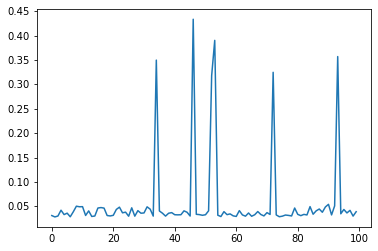

In [12]:
pl.plot(losses)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


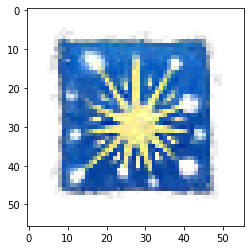

In [13]:
# Plots the learned CA
x, _ = pool.sample(1)
x = x.to(device)
x = model.evolve(x, N_ITERS)

imshow(x[0])

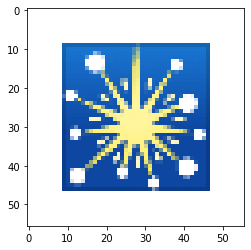

In [14]:
# Plots the true emoji
imshow(Pad(target, TARGET_PADDING))

In [16]:
# Make evolution video
model.makeVideo(video_size=IMAGE_SIZE, n_iters=N_ITERS*2, fname="video2.mkv", fps=10, rescaling=8)